In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2 as cv
import os
import random

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D,BatchNormalization, Dropout
from keras.models import Model
from keras import backend as K
from keras.models import load_model
from keras import utils

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [4]:
not_normal = load_images_from_folder("NOT_NORMAL")
normal = load_images_from_folder("NORMAL")

In [5]:
print(str(len(not_normal)/len(normal)) + " Is the rate of two categories ")

0.1 Is the rate of two categories 


In [6]:
#Data has imblance issue, 
#applying oversampeling method on not_normal 

In [17]:
not_normal[0].shape

(650, 1028, 3)

In [10]:
normal[0].shape

(1317, 1857, 3)

In [11]:
#difference in shape need to deal with

In [12]:
for img in normal:
    img = cv.resize(img, (1028,650))

In [51]:
normal_resized = [cv.resize(img, (1028,650)) for img in normal]
not_normal_resized = [cv.resize(img, (1028,650)) for img in not_normal]

In [52]:
normal_resized[0].shape

(650, 1028, 3)

In [53]:
generator = ImageDataGenerator(rotation_range=10 , brightness_range=[0.6,1.4], zoom_range=[0.8,1.2], horizontal_flip=True, height_shift_range=None,
                               width_shift_range=None)

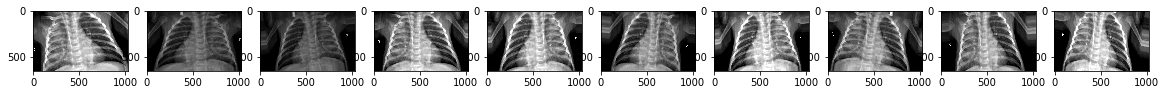

In [46]:
fig, axes = plt.subplots(1,10, figsize=(20,5))
for img,ax in zip(aug_images, axes):
    ax.imshow(img)

In [56]:
def aug_all(list):
    all_images =[]
    i=1
    for img in list:
        aug_iter = generator.flow(np.expand_dims(img,0))
        #generate 10 of each image
        aug_image = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]
        all_images.extend(aug_image)
        print(i)
        i+=1
    return(all_images)        

In [57]:
not_normal_aug = aug_all(not_normal_resized)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


In [58]:
len(not_normal_aug)


600

In [59]:
not_normal_aug[0].shape

(650, 1028, 3)

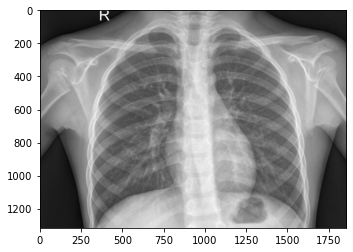

In [60]:
plt.imshow(normal[0])

In [61]:
train_X = normal_resized + not_normal_aug

In [62]:
train_X[0].shape

(650, 1028, 3)

In [63]:
len(normal_resized), len(not_normal_aug)

(600, 600)

In [64]:
train_Y = np.concatenate((np.zeros(600),np.ones(600)))

In [65]:
dataset = pd.DataFrame({'image': train_X, 'normal_or_not': train_Y})

In [66]:
#shuffeling dataframe
final_df = dataset.sample(frac=1)

In [67]:
final_df.head()

,image,normal_or_not
479,"[[[0, 0, 0], [0, 0, 0], [1, 1, 1], [0, 0, 0], ...",0.0
283,"[[[65, 65, 65], [65, 65, 65], [67, 67, 67], [6...",0.0
367,"[[[7, 7, 7], [49, 49, 49], [51, 51, 51], [60, ...",0.0
704,"[[[181, 181, 181], [179, 179, 179], [182, 182,...",1.0
489,"[[[34, 34, 34], [41, 41, 41], [47, 47, 47], [4...",0.0


In [19]:
print("Tensorflow-version:", tf.__version__)

Tensorflow-version: 2.6.0


In [20]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(650, 1028, 3))

29097984/29084464 [==============================] - 0s 0us/step


In [29]:
x=model_d.output
x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

In [32]:
preds=Dense(2,activation='softmax')(x)

In [33]:
model=Model(inputs=model_d.input,outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 650, 1028, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 656, 1034, 3) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 325, 514, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 325, 514, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [34]:
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

In [35]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 650, 1028, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 656, 1034, 3) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 325, 514, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 325, 514, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

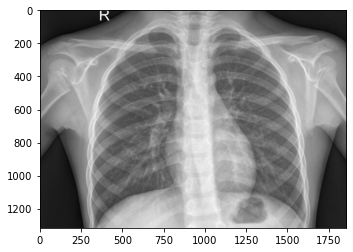

In [63]:
aug_iter = generator.flow(np.expand_dims(normal[0],0))
        #generate 10 of each image
aug_image = [next(aug_iter)[0].astype(np.uint8) for i in range(1)]


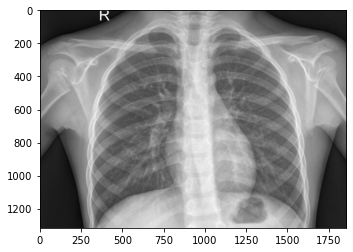

In [84]:
plt.imshow(normal[0])

In [85]:
normal[0].shape

(1317, 1857, 3)

In [92]:
new_normal.shape

(650, 1028, 3)

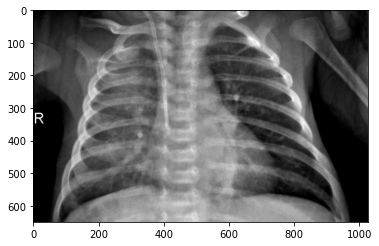

In [94]:
plt.imshow(not_normal[0])

In [68]:
train_X[610].shape

(650, 1028, 3)

In [73]:
train_X_arr = np.stack(train_X, axis=0)

In [75]:
train_X_arr.shape

(1200, 650, 1028, 3)